<a href="https://colab.research.google.com/github/etalab-ia/ami-ia/blob/master/ami_ia_dataviz_rr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Premiers pas avec Jupyter Notebook et Pandas 

Objectifs: 
  - charger un jeu de données de data.gouv
  - obtenir quelques statistiques basiques sur le jeu de données
  - visualiser les données 
  - nettoyer les données 
  - visualiser des données géo 


  Un exemple avec le jeu de données Alim'Confiance de datagouv à télécharger [ici](https://dgal.opendatasoft.com/explore/dataset/export_alimconfiance/export/?disjunctive.app_libelle_activite_etablissement&disjunctive.filtre&disjunctive.ods_type_activite) 

In [0]:
# importer les librairies dont on aura besoin 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
!pip install geopandas
import geopandas as gpd
from geopandas import GeoDataFrame

In [0]:
# lire le jeu de données en un objet "pandas dataframe"
df = pd.read_csv("https://dgal.opendatasoft.com/explore/dataset/export_alimconfiance/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B", sep = ";", header = 0)

In [0]:
# commande qui permet de visualiser les n premieres lignes d'une dataframe (5 par défaut)
df.head()

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_adresse,ods_type_activite
0,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22T13:00:00+02:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",Restaurant,34 rue Jacques de la Roque,Autres
1,LE CARDEUR DE BACCHUS,82183401700013,13100.0,AIX EN PROVENCE,3,2019-05-24T13:30:00+02:00,Restaurant,Très satisfaisant,NaN,"43.529969,5.446457",Restaurant,14 Forum des cardeurs,Autres
2,CARREFOUR BAR,40829886700016,13100.0,AIX EN PROVENCE,6,2019-05-21T12:30:00+02:00,Restaurant,Très satisfaisant,NaN,"43.525265,5.453713",Restaurant,2 rue Roux Alpherand,Autres
3,LES FILS A MAMAN,83283779300021,13100.0,AIX EN PROVENCE,0,2019-06-13T13:45:00+02:00,Restaurant,Très satisfaisant,NaN,"43.528498,5.447157",Restaurant,42 rue Verrerie,Autres
4,LE FOURNIL DES CORDELIERS,48466238200023,13100.0,AIX EN PROVENCE,1,2019-06-07T11:30:00+02:00,Boulangerie-Pâtisserie,Très satisfaisant,NaN,"43.52948,5.444981",Boulangerie-Pâtisserie,67 rue des Cordeliers,Autres


In [0]:
# donne le (nb de lignes, nb de colonnes)
df.shape

(38637, 13)

In [0]:
# regarder le type des variables
df.dtypes

APP_Libelle_etablissement              object
SIRET                                  object
Code_postal                           float64
Libelle_commune                        object
Numero_inspection                      object
Date_inspection                        object
APP_Libelle_activite_etablissement     object
Synthese_eval_sanit                    object
Agrement                               object
geores                                 object
filtre                                 object
ods_adresse                            object
ods_type_activite                      object
dtype: object

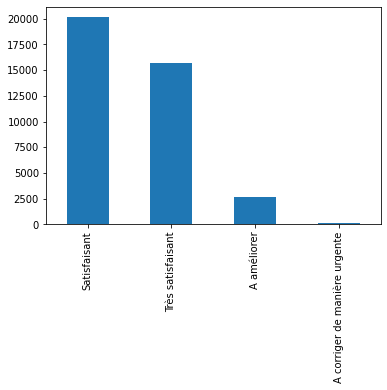

In [0]:
df['Synthese_eval_sanit'].value_counts().plot(kind='bar')

In [0]:
df["APP_Libelle_activite_etablissement"].value_counts().head(20)

Restaurant                                                     14800
Restauration collective                                         6451
Producteur fermier                                              1792
Transformation de lait ou produits laitiers                     1351
Boucherie-Charcuterie                                           1242
Transformation de produits carnés                               1156
Boulangerie-Pâtisserie                                          1055
Alimentation générale                                            938
Chaîne d'abattage de volaille/lagomorphe/petit gibier            936
Purification/Expédition de coquillages                           867
Découpe de viande de boucherie                                   675
Libre service                                                    467
Transport de denrées alimentaires                                427
Traiteur                                                         381
Entreposage de distribution de den

In [0]:
# On limite notre analyse aux restaurants 
df = df[df["APP_Libelle_activite_etablissement"]=="Restaurant"]

In [0]:
# créer une variable latitude et longitude à partir de la colonne geo res
set(type(x) for x in df["geores"].values.tolist())

{float, str}

In [0]:
df["lat"] = df["geores"].map(lambda x: float(x.split(",")[0] if pd.isnull(x)==False else x))
df["long"] = df["geores"].map(lambda x: float(x.split(",")[1] if pd.isnull(x)==False else x))

In [0]:
geo_df = df.dropna(subset =["lat", "long"])

Text(0.5, 1.0, 'Répartition des restaurants notés ')

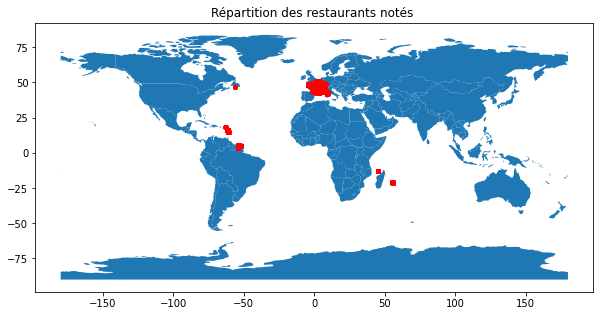

In [0]:
geometry = [Point(xy) for xy in zip(geo_df['long'], geo_df['lat'])]
gdf = GeoDataFrame(geo_df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)
plt.title("Répartition des restaurants notés ")

In [0]:
geo_df_fr = geo_df[(geo_df.lat>41.12)&(geo_df.lat<51.84)&(geo_df.long<11.3)&(geo_df.long>-6.25)]

Text(0.5, 1.0, 'Répartition des notes sanitaires sur le territoire')

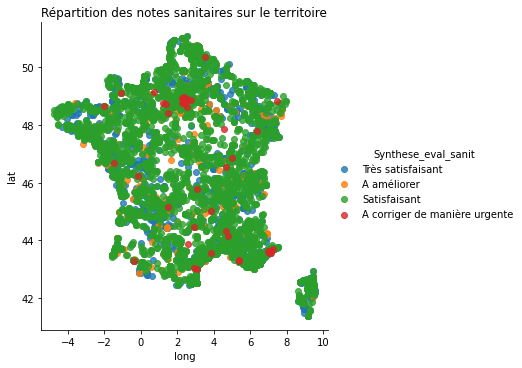

In [0]:
sns.lmplot('long', 'lat', data=geo_df_fr, hue='Synthese_eval_sanit', fit_reg=False)
plt.title("Répartition des notes sanitaires sur le territoire")

## Objectif de travail
Notre but est de contrôler l'inspection des restaurants. On s'est fixé les KPI suivants et on aimerait pouvoir les suivre :
* Nombre de controles mensuels par région, (EST-IL possible de mesurer en pourcentage ?)
* Taux de contrôles à améliorer ou à corriger par rapport aux controles effectués

### Nombre de contrôles par mois par région.
Pour cela il va falloir :
1. Connaître la région à laquelle le restaurant appartient 
2. Calculer le nombre de contrôles mensuels pour chacune des régions

In [0]:
from google.colab import files
uploaded = files.upload()

MessageError: ignored

In [0]:
import io
df_cities = pd.read_csv(io.BytesIO(uploaded['cities.csv']))
df_departments = pd.read_csv(io.BytesIO(uploaded['departments.csv']))
df_regions = pd.read_csv(io.BytesIO(uploaded['regions.csv']))

In [0]:
#for further processing we need to change the columns names for region
df_regions.columns= ['id', 'region_code', 'region_name', 'slug']
df_with_regions = pd.merge(df, df_cities, how= 'left', left_on = 'Code_postal', right_on = 'zip_code')
df_with_regions = pd.merge(df_with_regions, df_departments, how= 'left', left_on = 'department_code', right_on = 'code')
df_with_regions = pd.merge(df_with_regions, df_regions, how= 'left', on = 'region_code')
# the problem with this merging is that it generated many duplicates due to small cities having the same zip code
df_with_regions.head()

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_adresse,ods_type_activite,lat,long,id_x,department_code,insee_code,zip_code,name_x,slug_x,gps_lat,gps_lng,id_y,region_code,code,name_y,slug_y,id,region_name,slug
0,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22T13:00:00+02:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",Restaurant,34 rue Jacques de la Roque,Autres,43.531956,5.4468,4359.0,13,13001,13100.0,Aix-en-Provence,aix en provence,43.533834,5.509247,13.0,93,13,Bouches-du-Rhône,bouches du rhone,17.0,Provence-Alpes-Côte d'Azur,provence alpes cote dazur
1,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22T13:00:00+02:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",Restaurant,34 rue Jacques de la Roque,Autres,43.531956,5.4468,4376.0,13,13012,13100.0,Beaurecueil,beaurecueil,43.523233,5.546260,13.0,93,13,Bouches-du-Rhône,bouches du rhone,17.0,Provence-Alpes-Côte d'Azur,provence alpes cote dazur
2,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22T13:00:00+02:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",Restaurant,34 rue Jacques de la Roque,Autres,43.531956,5.4468,4471.0,13,13090,13100.0,Saint-Antonin-sur-Bayon,saint antonin sur bayon,43.517019,5.594303,13.0,93,13,Bouches-du-Rhône,bouches du rhone,17.0,Provence-Alpes-Côte d'Azur,provence alpes cote dazur
3,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22T13:00:00+02:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",Restaurant,34 rue Jacques de la Roque,Autres,43.531956,5.4468,4476.0,13,13095,13100.0,Saint-Marc-Jaumegarde,saint marc jaumegarde,43.553539,5.527096,13.0,93,13,Bouches-du-Rhône,bouches du rhone,17.0,Provence-Alpes-Côte d'Azur,provence alpes cote dazur
4,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22T13:00:00+02:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",Restaurant,34 rue Jacques de la Roque,Autres,43.531956,5.4468,4491.0,13,13109,13100.0,Le Tholonet,le tholonet,43.520782,5.504442,13.0,93,13,Bouches-du-Rhône,bouches du rhone,17.0,Provence-Alpes-Côte d'Azur,provence alpes cote dazur


In [0]:
#keep only original columns + regions
columns = df.columns.tolist()
columns += ['region_name', 'region_code']
df_with_regions = df_with_regions.filter(items=columns)
#remove duplicates
df_with_regions.drop_duplicates(ignore_index=True, inplace= True)

In [0]:
#First, let's check the number of controls by region
df_with_regions.groupby('region_code')['region_code'].count()

region_code
01      124
02      106
03       94
04       53
06       63
11     5566
24      253
27      372
28      493
32      894
44      741
52      532
53      565
75     1003
76     1239
84     1267
93     1101
94      280
COM      28
Name: region_code, dtype: int64

In [0]:
#We need a tracking to the month, so we need to work a bit on the time values
from datetime import datetime
def transform_date (string_date):
  datestr = string_date.split('+')[0] #remove the last bit of the data (ms) we don't need that
  return datetime.strptime(datestr,'%Y-%m-%dT%H:%M:%S') #convert the data into datetime object
df_with_regions['Date_inspection'] = df_with_regions['Date_inspection'].apply(lambda x : transform_date(x))

In [0]:
# Group the data by month and by region 
df_with_regions.groupby([pd.Grouper(key = 'Date_inspection', freq = 'm'),'region_code'])['region_code'].count()
# Group the data by month 
df_with_regions.groupby(pd.Grouper(key = 'Date_inspection', freq = 'm'))['region_code'].count()

Date_inspection
2019-05-31     774
2019-06-30    1607
2019-07-31    2121
2019-08-31    1480
2019-09-30    1329
2019-10-31    1361
2019-11-30    1306
2019-12-31     994
2020-01-31    1513
2020-02-29    1623
2020-03-31     650
2020-04-30      14
2020-05-31       2
Freq: M, Name: region_code, dtype: int64

In [0]:
df_